# Dataset 1 processing and descriptive analysis

This notebooks loads and processes the Dataset 1 and analyzes its mapping with PathMe, stratificating it by omic and by database.

Finally, it exports to the format ready to be used by DiffuPy/DiffuPath

In [2]:
import os 
import pybel
from pybel_tools.summary import plot_summary, count_top_centrality
import matplotlib.pyplot as plt

import json
import networkx as nx

from diffupath.constants import DEFAULT_DIFFUPATH_DIR, ROOT_RESULTS_DIR
from diffupath.pathme_processing import get_labels_by_db_and_omic_from_pathme, get_labels_by_db_and_omic_from_graph
from diffupath.utils import print_dict_dimensions, get_labels_set_from_dict, reduce_dict_dimension, get_count_and_labels_from_two_dim_dict, from_pickle, to_pickle, get_three_venn_intersections, random_disjoint_intersection_three_subsets
from diffupath.views import show_heatmap

from diffupy.process_network import process_graph_from_file
from diffupy.process_input import process_input_data
from diffupy.utils import lists_combinations, parse_xls_to_df, to_json
from diffupy.constants import *

## 1. Load and process dataset

### 1.1. Dataset excel file parsing

In [3]:
VALIDATION_PATH = os.path.join(ROOT_RESULTS_DIR, 'data', 'validation_datasets')
VALSET_1_PATH = os.path.join(VALIDATION_PATH, 'set1.xlsx')

##### Parsing parameters

In [4]:
set_entity_type = ['Genes', 'microRNA', 'Metabolite']
set_concentration = ['3µM', '20µM']
set_time_points = ['12h', '48h', '72h']

relevant_sheets = lists_combinations(set_entity_type, 
                                     lists_combinations(set_concentration, 
                                                        set_time_points)
                                    )
relevant_sheets

['Genes 3µM 12h',
 'Genes 3µM 48h',
 'Genes 3µM 72h',
 'Genes 20µM 12h',
 'Genes 20µM 48h',
 'Genes 20µM 72h',
 'microRNA 3µM 12h',
 'microRNA 3µM 48h',
 'microRNA 3µM 72h',
 'microRNA 20µM 12h',
 'microRNA 20µM 48h',
 'microRNA 20µM 72h',
 'Metabolite 3µM 12h',
 'Metabolite 3µM 48h',
 'Metabolite 3µM 72h',
 'Metabolite 20µM 12h',
 'Metabolite 20µM 48h',
 'Metabolite 20µM 72h']

In [5]:
relevant_cols = ['hgnc symbol', 
                 'MicroRNA', 
                 'Metabolite', 
                 'Mean p-value', 
                 'Mean FC', 
                 'Mean p-value', 
                 'FC', 
                 'fc', 
                 't.test', 
                 'Q.value'
                ]

cols_titles_mapping = {'hgnc symbol':NODE, 
                       'MicroRNA': NODE, 
                       'Metabolite': NODE, 
                       'Mean p-value': P_VALUE, 
                       'Mean FC': LOG_FC, 
                       'Mean p-value':P_VALUE, 
                       'FC': LOG_FC, 
                       'fc': LOG_FC
                      }

##### Dataset excel parsing

In [6]:
parsed_xls = parse_xls_to_df(VALSET_1_PATH,
                             min_row = 4,
                             relevant_sheets = relevant_sheets,
                             relevant_cols = relevant_cols
                            )

### 1.2. Process input data

In [7]:
processed_input_data = process_input_data(parsed_xls,
                                          cols_titles_mapping = cols_titles_mapping
                                          )
merged_processed_input_data = {label:score for subtype, entities in processed_input_data.items() for label, score in entities.items()}


## 2. Load background network graph

In [9]:
GRAPH_PATH = os.path.join(DEFAULT_DIFFUPATH_DIR, 'pickles', 'universe', 'pathme_universe_non_flatten_collapsed_names_no_isolates_16_03_2020.pickle')


PathMe Universe v1.0.0
Number of Nodes: 42272
Number of Edges: 105871
Number of Citations: 7695
Number of Authors: 0
Network Density: 5.92E-05
Number of Components: 435
Number of Warnings: 0


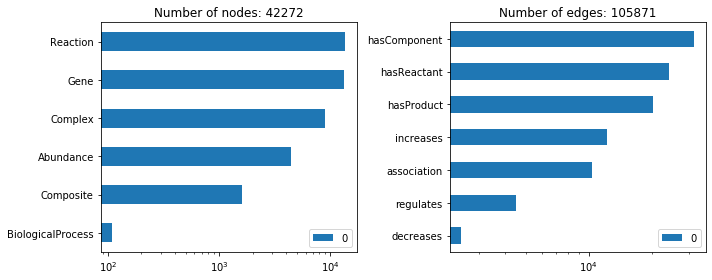

In [11]:
pathme_universe_graph_no_flatten = process_graph_from_file(GRAPH_PATH)

pathme_universe_graph_no_flatten.summarize()
plot_summary(pathme_universe_graph_no_flatten, plt, figsize=(10, 4))
plt.show()

In [11]:
bg_labels_from_pathmeuniverse_by_db_and_omic, bg_labels_from_pathmeuniverse_by_omic_and_db =  get_labels_by_db_and_omic_from_graph(pathme_universe_graph_no_flatten)

print_dict_dimensions(bg_labels_from_pathmeuniverse_by_db_and_omic, 'Entities in PathMeUniverse :')


Total number of  wikipathways: gene_nodes(2555), mirna_nodes(91), metabolite_nodes(637), bp_nodes(138),  
Total number of  kegg: gene_nodes(6048), mirna_nodes(122), metabolite_nodes(1770), bp_nodes(107),  
Total number of  reactome: gene_nodes(8617), mirna_nodes(13), metabolite_nodes(2682), bp_nodes(3),  
Total: 18001 


In [12]:
bg_labels_from_pathmeuniverse_by_db = reduce_dict_dimension(bg_labels_from_pathmeuniverse_by_db_and_omic)
print_dict_dimensions(bg_labels_from_pathmeuniverse_by_db, 'Entities in PathMeUniverse :')

Total number of  wikipathways: 3421  
Total number of  kegg: 8047  
Total number of  reactome: 11315  
Total: 18001 


In [13]:
bg_labels_from_pathmeuniverse_by_omic = reduce_dict_dimension(bg_labels_from_pathmeuniverse_by_omic_and_db)
print_dict_dimensions(bg_labels_from_pathmeuniverse_by_omic, 'Entities in PathMeUniverse :')

Total number of  gene_nodes: 13282  
Total number of  mirna_nodes: 171  
Total number of  metabolite_nodes: 4306  
Total number of  bp_nodes: 248  
Total: 18001 


## 3. Mapping

In [14]:
from diffupy.process_input import map_labels_input
from diffupy.process_input import mapping_statistics

##### Quantitative

In [21]:
mapping_by_database_and_entity = map_labels_input(input_labels=merged_processed_input_data,
                                                  background_labels=bg_labels_from_pathmeuniverse_by_db_and_omic,
                                                  show_descriptive_stat= True,
                                                  check_substrings = ['mirna_nodes']
                                                  )

mapping_by_database_and_entity_statistics = mapping_statistics(merged_processed_input_data, 
                                                               mapping_by_database_and_entity)

Mapping descriptive statistics

wikipathways:
gene_nodes  ((929, 0.3342929111191076))
mirna_nodes  ((16, 0.6153846153846154))
metabolite_nodes  ((92, 0.37398373983739835))
bp_nodes  ((14, 0.4))
total  ((1051, 0.2171039041520347))

kegg:
gene_nodes  ((1780, 0.6405181720043182))
mirna_nodes  ((17, 0.6538461538461539))
metabolite_nodes  ((69, 0.2804878048780488))
bp_nodes  ((20, 0.5714285714285714))
total  ((1886, 0.38958892790745714))

reactome:
gene_nodes  ((1413, 0.5084562792371357))
mirna_nodes  ((5, 0.19230769230769232))
metabolite_nodes  ((124, 0.5040650406504065))
bp_nodes  ((1, 0.02857142857142857))
total  ((1543, 0.31873579838876265))

total:
gene_nodes  ((2779, 0.5740549473249329))
mirna_nodes  ((26, 0.005370791158851477))
metabolite_nodes  ((246, 0.05081594711836397))
bp_nodes  ((35, 0.007229911175376988))
total  ((3086, 0.6374715967775253))





##### Descriptive data view

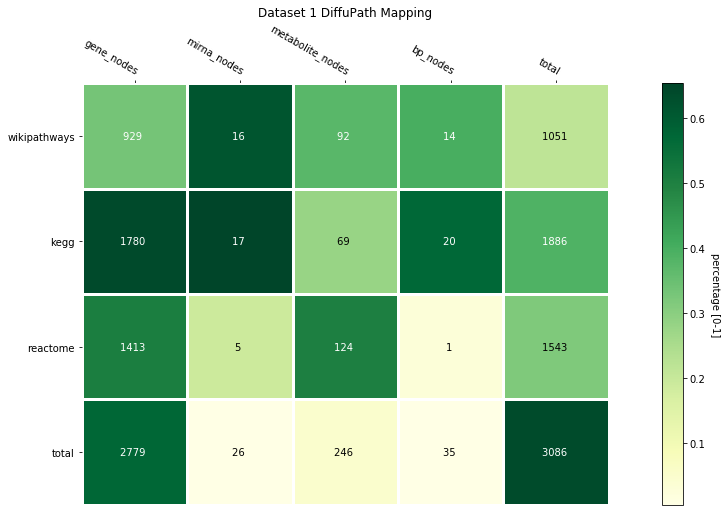

In [17]:
count, percentage, db_labels, entity_labels  = get_count_and_labels_from_two_dim_dict(mapping_by_database_and_entity_statistics)

show_heatmap(count, percentage, db_labels, entity_labels, 'Dataset 2 DiffuPath Mapping')

##### Save mapping by_db_and_entity to exportable .json file

In [23]:
MAPPING_OUTPUT_PATH = os.path.join(ROOT_RESULTS_DIR, 'data', 'input_mappings', 'dataset_1_mapping.json')
to_json(mapping_by_database_and_entity, MAPPING_OUTPUT_PATH)